# Preliminaries

## Importing Packages and Loading The Data

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings

# Preproccessing
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
from xgboost import XGBClassifier

# Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

# Supressing warnings
warnings.filterwarnings('ignore')

## Basic Data Inspection

In [ ]:
data_path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(data_path, index_col='customerID')
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

## Preprocessing 

Let's carry out some preprocessing steps, including **imputing**, **type conversions** and **encoding**

In [ ]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
	imputer = SimpleImputer(
		strategy='constant',
		fill_value=0,
		missing_values=' '
	)

	filledDf = pd.DataFrame(
		imputer.fit_transform(df),
		columns=df.columns
	)

	return filledDf


def type_convertions(X: pd.DataFrame) -> pd.DataFrame:
	df = X.copy()
	df['TotalCharges'] = df['TotalCharges'].astype(dtype='float64')
	df['MonthlyCharges'] = df['MonthlyCharges'].astype(dtype='float64')
	df['SeniorCitizen'] = df['SeniorCitizen'].astype(dtype='int64')
	df['tenure'] = df['tenure'].astype(dtype='int64')

	df['is_male'] = pd.Series(1 if i == 'Male' else 0 for i in df['gender'])
	df.drop(columns=['gender'], inplace=True)

	boolCols = [
		'Partner',
		'Dependents',
		'PhoneService',
		'PaperlessBilling',
		'Churn'
	]

	for boolCol in boolCols:
		df[boolCol] = pd.Series(1 if i == 'Yes' else 0 for i in df[boolCol])
	
	return df

def oh_encoding(X: pd.DataFrame) -> pd.DataFrame:
	df = X.copy()
	OHColumns = [
		'MultipleLines',
		'InternetService',
		'OnlineSecurity',
		'DeviceProtection',
		'TechSupport',
		'StreamingTV',
		'StreamingMovies',
		'Contract',
		'PaymentMethod',
		'OnlineBackup'
	]

	encoder = OneHotEncoder(cols=OHColumns, use_cat_names=True)
	encodedDf = encoder.fit_transform(df)
	return encodedDf



In [4]:
# Imputing
clean_df = impute(df)

# OneHotEncoding
clean_df = oh_encoding(clean_df)

# Changing some types (including boolean features to int type)
clean_df = type_convertions(clean_df)

# clean_df.sample(5)


# Model



## Baseline

Let's define a function which will evaluate the model and make simple model to get a baseline score

In [ ]:
def score_model(X : pd.DataFrame, y : pd.Series, model=XGBClassifier(objective='binary:logistic')) -> pd.Series:
	scores = []
	kf = StratifiedKFold(n_splits=5)
	for train_idx, val_idx in kf.split(X, y):
		X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
		y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
		model.fit(X_train, y_train)
		y_pred = pd.Series(model.predict_proba(X_val)[:, 1])
		scores.append(average_precision_score(y_val, y_pred))

	return np.mean(scores) # get score

In [6]:
X = clean_df.copy()
y = X.pop('Churn')

print(f'Baseline score: {score_model(X, y):.4f}')

Baseline score: 0.6225


Hypertuning parameters using optuna package

```python
import optuna

X = clean_df.copy()
y = X.pop('Churn')

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.5, log=True), 
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 20.0, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 10.0, log=True), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    xgb = XGBClassifier(
        **params,
        random_state=0,
        n_jobs=4,
		objective="binary:logistic",
    	eval_metric=["logloss", "aucpr"]
    )

    score = score_model(X, y, model=xgb)
    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print("Best Average Precision:", study.best_value)
```

In [7]:
best_parameters = {
	'n_estimators': 2541, 
	'learning_rate': 0.002320487282095858, 
	'max_depth': 3, 
	'subsample': 0.34314715429172016, 
	'colsample_bytree': 0.816572280598113, 
	'reg_lambda': 0.003133162062110226, 
	'reg_alpha': 0.0035892491773983153, 
	'min_child_weight': 9
}

final_model = XGBClassifier(eval_metric=["logloss", "aucpr"], **best_parameters)
print(f'Score after tuning: {score_model(X, y, final_model):.4f}')
print(f'Churn rate: {sum(y) / len(y):.4f}')

Score after tuning: 0.6728
Churn rate: 0.2654


Averege precition of ~0.6728 means model's ranking is about **2.5 times better than random**, which is sufficient result for "top-k" customers strategy.

## Calculating business model values

Let's assume our *retention action* is making a **discount of 15% for 3 month**.  

I approximate CLV as monthly revenue times expected remaining lifetime. Expected lifetime is assigned by contract type, reflecting that longer contracts imply higher retained value.

| Contract type | Expected lifetime |
|------------------|-------------------|
| Month-to-month | 3 months |
| One year  | 12 month |
| Two year  | 24 month |

For each client expected profit is calculated as $${expectedProfit} = p(save) \times p(Churn) \times {lostValue} - {actionCost}$$, where
$$p(save) - \text{probability of saving client after retention action}$$
$$p(Churn) - \text{probability of churn (model prediction)}$$
$$actionCost - \text{retention action cost}$$
$$lostValue - \text{expected value from keeping client}$$

After calculating expected profit for every client I sort them in descending order, calculate cumulative profits and plot **Cumulative Profit by Amount of Targeted Clients**.

In [16]:
# Probability of churn predictions
def strkfold_predictions(X : pd.DataFrame, y : pd.Series, model=XGBClassifier(objective='binary:logistic')) -> pd.Series:
	preds = pd.Series()
	kf = StratifiedKFold(n_splits=5)
	for train_idx, val_idx in kf.split(X, y):
		X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
		y_train = y.iloc[train_idx]
        
		model.fit(X_train, y_train)
		preds_i = pd.Series(model.predict_proba(X_val)[:, 1], index=val_idx)
		preds = pd.concat([preds, preds_i], axis=0)

	return preds.rename('ChurnProbability') # predictions

# Calculating expected profit
def calculate_expected_profit(X: pd.DataFrame, y: pd.Series, y_pred: pd.Series, pSave=0.25) -> pd.Series:
	full_df = pd.concat([X, y, y_pred], axis=1)

	# Retention action price
	discountRate = 0.15
	months = 3
	actionCost = full_df['MonthlyCharges'] * discountRate * months

	# Value lost on client's churn
	remainingLifeTime = full_df['Contract_Month-to-month'] * 3 + full_df['Contract_One year'] * 12 + full_df['Contract_Two year'] * 24
	lostValue = full_df['MonthlyCharges'] * remainingLifeTime

	expectedProfit = full_df['ChurnProbability'] * pSave * lostValue - actionCost
	expectedProfit = expectedProfit.rename('ExpectedProfit')
	return expectedProfit


# Plot expected profit by k (amount of cliens 'saved')
def plot_profit(X: pd.DataFrame, y: pd.Series, model=XGBClassifier(objective='binary:logistic'), pSave=0.25) -> plt.axes:
	y_pred = strkfold_predictions(X, y, model)
	expectedProfit = calculate_expected_profit(X, y, y_pred, pSave)
	expectedProfit.sort_values(ascending=False, ignore_index=True, inplace=True)
	commProfit = [0] * len(expectedProfit)
	for i in range(1, len(expectedProfit)):
		commProfit[i] = expectedProfit[i] + commProfit[i - 1]
	idx = expectedProfit.index

	plt.figure(figsize=(10, 5))
	ax = sns.lineplot(
		x=idx,
		y=commProfit
	)
	ax.set_title('Cumulative Profit by K (clients targeted)')
	ax.set_xlabel('K')
	ax.set_ylabel('Cumulative Profit')
	ax.set_xticks(np.arange(0, 7100, 500))
	
	return ax

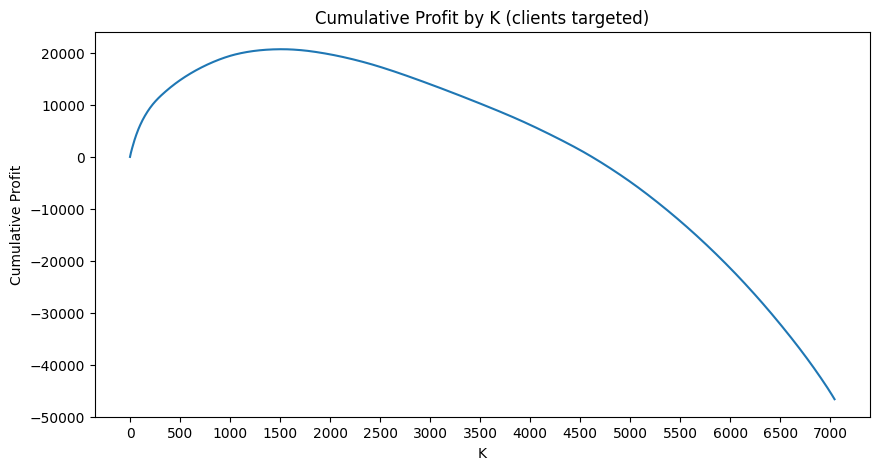

In [17]:
X = clean_df.copy()
y = X.pop('Churn')

ax = plot_profit(X, y, final_model)
plt.show()

Plot clearly shows that $k = 1500$ is the best value for this dataset. So we should target first 1500 clients in order to get maximum profit.

## Further analylis

Depending on $p(save)$ value optimal value of k could vary. Since dataset doesn't contain information needed for calculating *true value* of $p(save)$ let's have a look at a couple of different *optimal k values* for different $p(save)$ values. 

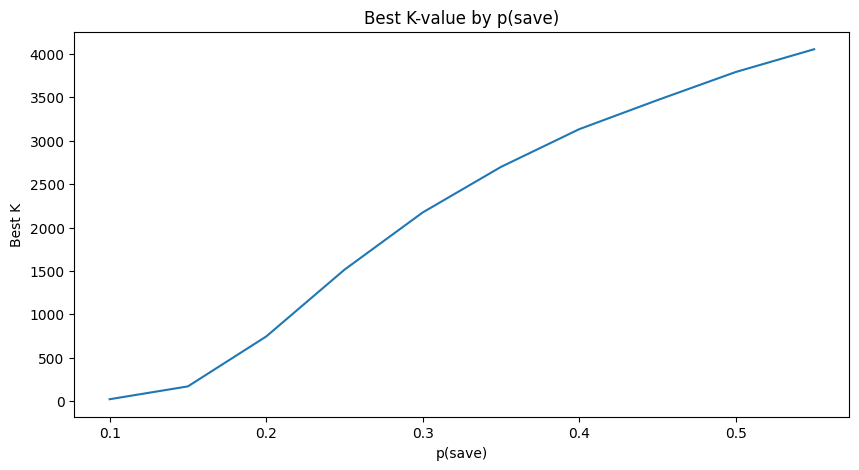

In [18]:
p_values = np.arange(0.1, 0.6, 0.05)
y_pred = strkfold_predictions(X, y, final_model)
k_values = [
	sum(calculate_expected_profit(X, y, y_pred, pSave=p) > 0) 
	for p in p_values
]
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
	x=p_values,
	y=k_values
)
ax.set_title('Best K-value by p(save)')
ax.set_xlabel('p(save)')
ax.set_ylabel('Best K')

plt.show()


As expected, the bigger probability of saving client is, the more clients we should target

# Model Explainability

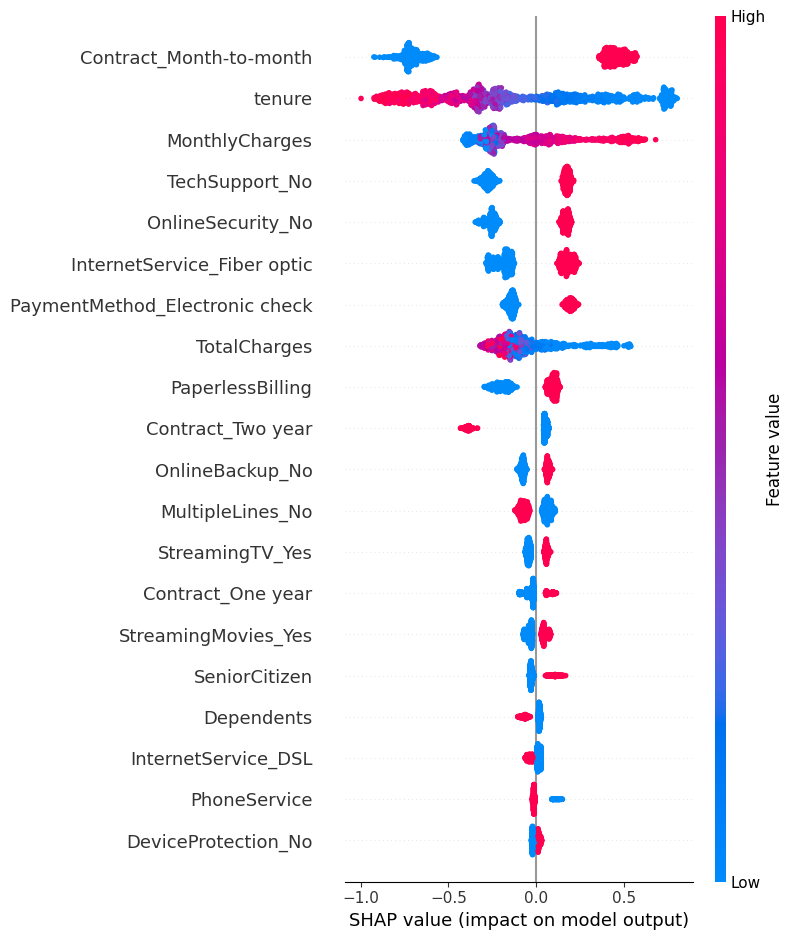

In [19]:
import shap

X_sample = X.sample(len(X) // 6)

explainer = shap.Explainer(final_model)
sv = explainer(X_sample)

shap.summary_plot(sv)

According to shap summary plot, properties indicating clients that are tend to leave are the following (from more to less important):
- Low tenure
- High monthly charges
- Month-to-month contract type
- Low amount of total charges
- Electronic Check payment method
